In [1]:
:e ImportQualifiedPost
:e FlexibleContexts
:e BlockArguments
:e TupleSections
:e FlexibleContexts
:e OverloadedStrings
:e LambdaCase

import Control.Monad.Bayes.Class
import Control.Monad.Bayes.Enumerator
import Control.Monad.Bayes.Weighted
import Control.Monad.Bayes.Sampler.Strict

import Control.Monad
import Data.List
import Data.Ord
import Control.Arrow (first)
import Data.Text (pack, Text)
import Numeric.Log
import Control.Arrow (second)

:l ../plotting.hs

# Sampling

Before discussing inference, we should understand how to sample from models. This notebook explains how to do that.

## Discrete distribution
We'll start with a very simple model, namely:

In [2]:
model :: MonadSample m => m Bool
model = bernoulli 0.7

To take a sample, do:

In [3]:
sampler model

True

Or with a fixed seed:

In [4]:
sampleIOfixed model

True

To take multiple samples, you could rerun `sampler` many times, but it's somewhat more in the probabilistic programming spirit to instead define a distribution over multiple draws from `model` and then just sample once, as follows:

In [5]:
multipleDraws :: MonadSample m => m [Bool]
multipleDraws = replicateM 10 model

draws <- sampler multipleDraws

draws

[True,True,True,True,True,True,True,True,True,True]

We can write a function to convert a list of samples to an empirical distribution, like so:

In [6]:
emp = toEmpirical draws :: [(Bool, Double)]

emp

[(True,1.0)]

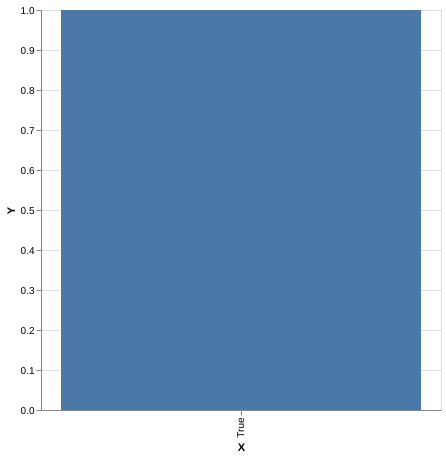

In [7]:
plot $ first (pack . show) <$> emp

In fact, we could lean even further into the spirit of probabilistic programming, and transform `model` into a distribution over plots, and sample from that:

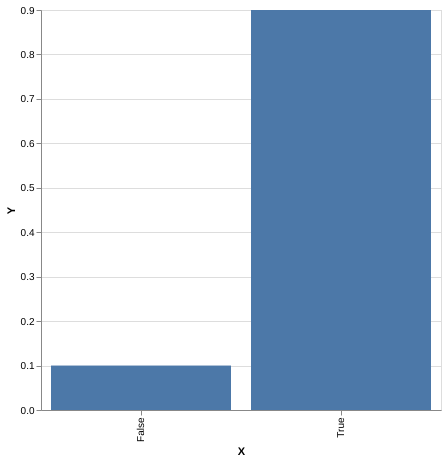

In [8]:
distributionOverPlots :: MonadSample m => m VegaLiteLab -- the type of plots
distributionOverPlots = plot . fmap (first (pack . show)) . toEmpirical <$> replicateM 10 model

sampler distributionOverPlots


## Continuous distributions

Consider normal distribution:

In [9]:
model2 :: MonadSample m => m Double
model2 = normal 0 1

Sampling is no different to before:

In [10]:
sampler model2

-0.42248086034607285

And as before, to obtain multiple draws:

In [11]:
multipleDraws2 :: MonadSample m => m [Double]
multipleDraws2 = replicateM 10 model2

draws2 <- sampler multipleDraws2

draws2

[-0.6298331533642196,0.5426824263412585,0.15386678332481174,0.7554618435540722,-1.974486100467846e-2,0.8318368556611232,-1.0746630202842478,0.6945010970642304,-0.20060636653459119,-0.6851476854633729]

We'd like to view a histogram of samples, which in the limit of many samples should tend to the PDF of a normal distribution.

Again, we could generate a histogram from a drawn list of samples:

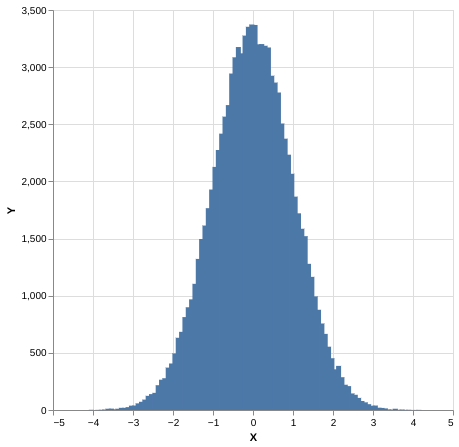

In [12]:
samples <- sampler $ replicateM 100000 (weighted model2)
plot . histogramToList . histogram 100 $ samples

In [13]:
:t weighted

weighted :: forall {m :: * -> *} {a}. Weighted m a -> m (a, Log Double)

but it's nicer to apply a `histogram` function to multiple draws to define a distribution over histograms from which we'll sample.\
In that approach a distribution is composed and transformed first and the sampling is clearly split from the distribution definition.

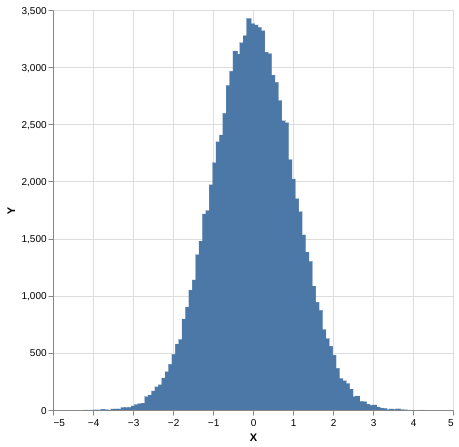

In [14]:
sampler $ plot . histogramToList . histogram 100 <$> replicateM 100000 (weighted model2)

Mixture model:

In [15]:
model3 = do
    p <- bernoulli 0.7
    if p then normal 0 1 else normal 3 1

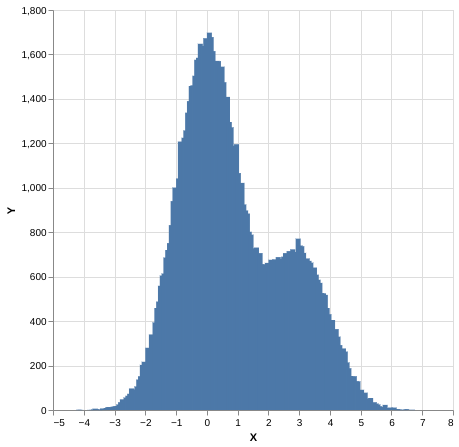

In [16]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model3)


# Weighted Sampling

For models with factor statements, we cannot just sample. For example, consider a distribution which is conditioned to positive values only:

In [17]:
model4 = do
    p <- bernoulli 0.7
    out <- if p then normal 0 1 else normal 3 1
    condition (out > 0)
    return out


`condition` is a special case of `factor` statement for binary factors.

Here, we use `weighted` to convert `model4` into a distribution over pairs of numbers and their weights. We then sample from that. To view 

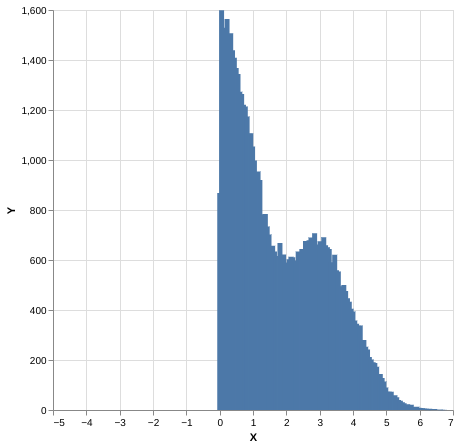

In [18]:
sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model4)

We could ignore the `condition` statement using `unweighted`, as in:

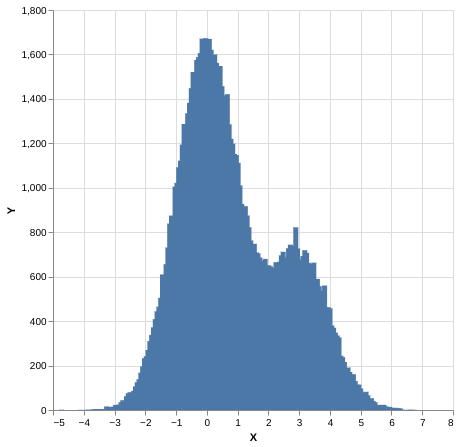

In [19]:
sampler . unweighted $ plot . histogramToList . histogram 200 <$> replicateM 100000 (weighted $ unweighted model4)


But obviously, we'd like to take samples from the posterior. We can do so as follows:

In [20]:
draws4 <- sampler $ replicateM 10 $ weighted model4
draws4

[(-0.8016735373234715,0.0),(3.3231803560732147,1.0),(2.3947312406224994,1.0),(1.2624529536091929,1.0),(0.7001960528810024,1.0),(2.0409636526746406,1.0),(-0.15091441390976792,0.0),(-0.7599524641552119,0.0),(1.0806327398434834,1.0),(-0.9655646185813256,0.0)]

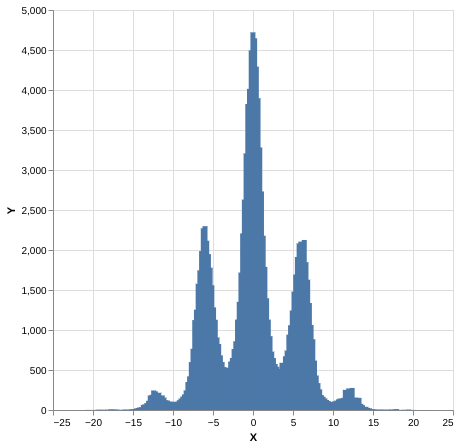

In [21]:
model5 :: MonadInfer m => m Double
model5 = do
    x <- normal 0 5
    (factor . Exp) (cos x)
    return x

sampler $ 
    plot . histogramToList . histogram 200
    <$> replicateM 100000 (weighted model5)